**Predição da Probabilidade de Ocorrência de Acidentes Graves**

**Este projeto tem como objetivo desenvolver um modelo preditivo robusto para classificar a gravidade de acidentes de trânsito, com base em variáveis como tipo de veículo envolvido, fatores contribuintes, localização (bairro, ruas, CEP), dia da semana, hora do dia, entre outras características operacionais e temporais. Com os insights gerados pelo modelo, é possível identificar padrões associados a colisões graves, permitindo que autoridades e gestores públicos adotem estratégias mais eficazes de prevenção, fiscalização e educação no trânsito. O modelo também serve como base para a construção de sistemas de alerta e painéis inteligentes, contribuindo para cidades mais seguras e inteligentes.**

In [ ]:
# Importando Bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
from datetime import timedelta
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [ ]:
# Carregando a base de dados
df = pd.read_csv('/content/Motor_Vehicle_Collisions_-_Crashes.csv')

In [ ]:
# Observando
df.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
3,09/11/2021,9:35,BROOKLYN,11208.0,40.667202,-73.866500,"(40.667202, -73.8665)",NaN,NaN,1211 LORING AVENUE,...,NaN,NaN,NaN,NaN,4456314,Sedan,NaN,NaN,NaN,NaN
4,12/14/2021,8:13,BROOKLYN,11233.0,40.683304,-73.917274,"(40.683304, -73.917274)",SARATOGA AVENUE,DECATUR STREET,NaN,...,NaN,NaN,NaN,NaN,4486609,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Observando a quantidade de linhas e colunas
df.shape

(2102132, 29)

In [ ]:
# Informações sobre os tipos de variáveis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2102132 entries, 0 to 2102131
Data columns (total 29 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   CRASH DATE                     object 
 1   CRASH TIME                     object 
 2   BOROUGH                        object 
 3   ZIP CODE                       object 
 4   LATITUDE                       float64
 5   LONGITUDE                      float64
 6   LOCATION                       object 
 7   ON STREET NAME                 object 
 8   CROSS STREET NAME              object 
 9   OFF STREET NAME                object 
 10  NUMBER OF PERSONS INJURED      float64
 11  NUMBER OF PERSONS KILLED       float64
 12  NUMBER OF PEDESTRIANS INJURED  int64  
 13  NUMBER OF PEDESTRIANS KILLED   int64  
 14  NUMBER OF CYCLIST INJURED      int64  
 15  NUMBER OF CYCLIST KILLED       int64  
 16  NUMBER OF MOTORIST INJURED     int64  
 17  NUMBER OF MOTORIST KILLED      int64  
 18  CO

In [ ]:
# Dados estatísticos
df.describe()

,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,COLLISION_ID
count,1.866706e+06,1.866706e+06,2.102114e+06,2.102101e+06,2.102132e+06,2.102132e+06,2.102132e+06,2.102132e+06,2.102132e+06,2.102132e+06,2.102132e+06
mean,4.062453e+01,-7.374638e+01,3.133850e-01,1.512772e-03,5.700451e-02,7.501908e-04,2.719953e-02,1.170240e-04,2.253317e-01,6.217497e-04,3.179518e+06
std,2.012329e+00,3.777220e+00,7.031207e-01,4.103224e-02,2.449764e-01,2.791276e-02,1.647046e-01,1.086102e-02,6.643142e-01,2.726068e-02,1.505804e+06
min,0.000000e+00,-2.013600e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.200000e+01
25%,4.066769e+01,-7.397481e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.161653e+06
50%,4.072066e+01,-7.392724e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.687316e+06
75%,4.076960e+01,-7.386674e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.213088e+06
max,4.334444e+01,0.000000e+00,4.300000e+01,8.000000e+00,2.700000e+01,6.000000e+00,4.000000e+00,2.000000e+00,4.300000e+01,5.000000e+00,4.738871e+06


In [ ]:
# Combina as colunas de data e hora, e converte para datetime
df['CRASH_DATETIME'] = pd.to_datetime(df['CRASH DATE'] + ' ' + df['CRASH TIME'], errors='coerce')

In [ ]:
# Ordenar e definir como índice
df = df.sort_values('CRASH_DATETIME').set_index('CRASH_DATETIME')

In [ ]:
df.drop(columns=['CRASH DATE', 'CRASH TIME'], inplace=True)

In [ ]:
# Criando variáveis temporais
df['CRASH_HOUR'] = df.index.hour
df['CRASH_WEEKDAY'] = df.index.weekday
df['CRASH_MONTH'] = df.index.month
df['CRASH_YEAR'] = df.index.year

In [ ]:
df.head()

,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,...,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,CRASH_HOUR,CRASH_WEEKDAY,CRASH_MONTH,CRASH_YEAR
CRASH_DATETIME,,,,,,,,,,,,,,,,,,,,,
2012-07-01 00:05:00,MANHATTAN,10036,40.762127,-73.997387,"(40.7621266, -73.9973865)",11 AVENUE,WEST 44 STREET,NaN,0.0,0.0,...,37632,PASSENGER VEHICLE,BUS,NaN,NaN,NaN,0,6,7,2012
2012-07-01 00:05:00,NaN,NaN,40.697753,-73.813916,"(40.6977532, -73.8139159)",NaN,NaN,NaN,1.0,0.0,...,2999940,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN,0,6,7,2012
2012-07-01 00:10:00,BROOKLYN,11223,40.588868,-73.972745,"(40.5888678, -73.9727446)",WEST 3 STREET,BOUCK COURT,NaN,0.0,0.0,...,116256,PASSENGER VEHICLE,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,0,6,7,2012
2012-07-01 00:10:00,NaN,NaN,40.733610,-73.923840,"(40.73361, -73.9238405)",NaN,NaN,NaN,1.0,0.0,...,3044659,PASSENGER VEHICLE,PASSENGER VEHICLE,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,0,6,7,2012
2012-07-01 00:20:00,BROOKLYN,11215,40.677406,-73.983048,"(40.6774056, -73.9830482)",4 AVENUE,UNION STREET,NaN,0.0,0.0,...,175808,UNKNOWN,BICYCLE,NaN,NaN,NaN,0,6,7,2012


In [ ]:
df.tail()

,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,...,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,CRASH_HOUR,CRASH_WEEKDAY,CRASH_MONTH,CRASH_YEAR
CRASH_DATETIME,,,,,,,,,,,,,,,,,,,,,
2024-07-06 23:09:00,NaN,NaN,NaN,NaN,NaN,BROOKLYN BRIDGE,NaN,NaN,0.0,0.0,...,4738743,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,23,5,7,2024
2024-07-06 23:15:00,NaN,NaN,40.605568,-74.031180,"(40.605568, -74.03118)",BELT PARKWAY,NaN,NaN,1.0,0.0,...,4738739,Station Wagon/Sport Utility Vehicle,Motorcycle,NaN,NaN,NaN,23,5,7,2024
2024-07-06 23:21:00,QUEENS,11104.0,40.747340,-73.916910,"(40.74734, -73.91691)",NaN,NaN,39-53 47 STREET,0.0,0.0,...,4738470,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,23,5,7,2024
2024-07-06 23:35:00,NaN,NaN,40.696663,-73.980850,"(40.696663, -73.98085)",BROOKLYN QUEENS EXPRESSWAY,NaN,NaN,0.0,0.0,...,4738457,Sedan,Box Truck,NaN,NaN,NaN,23,5,7,2024
2024-07-06 23:46:00,QUEENS,11429.0,40.711628,-73.729385,"(40.711628, -73.729385)",HEMPSTEAD AVENUE,225 STREET,NaN,0.0,0.0,...,4738439,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN,23,5,7,2024


In [ ]:
# Observando valores duplicados
df.duplicated().sum()

np.int64(0)

In [ ]:
# Verificando a existência de valores nulos
df.isnull().sum()

,0
BOROUGH,653880
ZIP CODE,654139
LATITUDE,235426
LONGITUDE,235426
LOCATION,235426
ON STREET NAME,448307
CROSS STREET NAME,798104
OFF STREET NAME,1746198
NUMBER OF PERSONS INJURED,18
NUMBER OF PERSONS KILLED,31


In [ ]:
# Porcentagem de valores nulos por coluna
percentual_nulos = (df.isnull().sum() / len(df)) * 100
print(percentual_nulos.round(2))

BOROUGH                          31.11
ZIP CODE                         31.12
LATITUDE                         11.20
LONGITUDE                        11.20
LOCATION                         11.20
ON STREET NAME                   21.33
CROSS STREET NAME                37.97
OFF STREET NAME                  83.07
NUMBER OF PERSONS INJURED         0.00
NUMBER OF PERSONS KILLED          0.00
NUMBER OF PEDESTRIANS INJURED     0.00
NUMBER OF PEDESTRIANS KILLED      0.00
NUMBER OF CYCLIST INJURED         0.00
NUMBER OF CYCLIST KILLED          0.00
NUMBER OF MOTORIST INJURED        0.00
NUMBER OF MOTORIST KILLED         0.00
CONTRIBUTING FACTOR VEHICLE 1     0.33
CONTRIBUTING FACTOR VEHICLE 2    15.59
CONTRIBUTING FACTOR VEHICLE 3    92.83
CONTRIBUTING FACTOR VEHICLE 4    98.38
CONTRIBUTING FACTOR VEHICLE 5    99.56
COLLISION_ID                      0.00
VEHICLE TYPE CODE 1               0.67
VEHICLE TYPE CODE 2              19.28
VEHICLE TYPE CODE 3              93.10
VEHICLE TYPE CODE 4      

In [ ]:
# Excluindo as colunas que não iremo utilizar e com mais de 80% de nulos
df.drop(columns=['OFF STREET NAME', 'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4',
                 'CONTRIBUTING FACTOR VEHICLE 5', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4',
                 'COLLISION_ID','VEHICLE TYPE CODE 5', 'LOCATION'], inplace=True)





In [ ]:
# Removendo valores nulos abaixo de 12%
df.dropna(subset=['LATITUDE', 'LONGITUDE', 'CONTRIBUTING FACTOR VEHICLE 1',
                  'VEHICLE TYPE CODE 1', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED' ], inplace=True)

In [ ]:
# Observando o valor que mais se repete na variável 'ON STREET NAME'
df['ON STREET NAME'].value_counts().head(10)

,count
ON STREET NAME,
BROADWAY,15840
ATLANTIC AVENUE,14124
BELT PARKWAY,12068
3 AVENUE,11502
NORTHERN BOULEVARD,10232
LONG ISLAND EXPRESSWAY,9208
BROOKLYN QUEENS EXPRESSWAY,8880
2 AVENUE,8735
LINDEN BOULEVARD,8546


In [ ]:
# Vamos substituir os valores nulos pelo categoria que mais se repete
df['ON STREET NAME'].fillna('BROADWAY', inplace=True)

In [ ]:
# Observando o valor que mais se repete na variável 'CROSS STREET NAME'
df['CROSS STREET NAME'].value_counts().head(10)

,count
CROSS STREET NAME,
3 AVENUE,9062
BROADWAY,8901
2 AVENUE,8283
5 AVENUE,6881
3 AVENUE,6440
8 AVENUE,6367
7 AVENUE,6236
BROADWAY,5990
1 AVENUE,5104


In [ ]:
# Vamos substituir os valores nulos pelo categoria que mais se repete
df['CROSS STREET NAME'].fillna('3 AVENUE', inplace=True)

In [ ]:
# Observando o valor que mais se repete na variável ZIP CODE
df['ZIP CODE'].value_counts().head(10)

,count
ZIP CODE,
11207.0,20343
11236.0,14734
11203.0,13348
11234.0,13299
11385.0,13072
11208.0,13031
11212.0,12971
11101.0,12944
11226.0,12573


In [ ]:
# Vamos substituir os valores nulos pelo categoria que mais se repete
df['ZIP CODE'].fillna('11207.0', inplace=True)

In [ ]:
# Observando o valor que mais se repete na variável 'CONTRIBUTING FACTOR VEHICLE 2
df['CONTRIBUTING FACTOR VEHICLE 2'].value_counts().head(10)

,count
CONTRIBUTING FACTOR VEHICLE 2,
Unspecified,1321492
Driver Inattention/Distraction,84967
Other Vehicular,28671
Following Too Closely,16384
Failure to Yield Right-of-Way,15368
Passing or Lane Usage Improper,11560
Fatigued/Drowsy,8564
Passing Too Closely,8060
Turning Improperly,7472


In [ ]:
# Vamos substituir os valores nulos pelo categoria que mais se repete
df['CONTRIBUTING FACTOR VEHICLE 2'].fillna('Unspecified', inplace=True)

In [ ]:
# Observando o valor que mais se repete na variável 'VEHICLE TYPE CODE 2'
df['VEHICLE TYPE CODE 2'].value_counts().head(10)

,count
VEHICLE TYPE CODE 2,
Sedan,377839
Station Wagon/Sport Utility Vehicle,302544
PASSENGER VEHICLE,263203
SPORT UTILITY / STATION WAGON,116732
UNKNOWN,69894
Taxi,34566
Bike,30952
Pick-up Truck,29013
Box Truck,26391


In [ ]:
# Vamos substituir os valores nulos pelo categoria que mais se repete
df['VEHICLE TYPE CODE 2'].fillna('Sedan', inplace=True)

In [ ]:
# Observando o valor que mais se repete na variável 'BOROUGH'
df['BOROUGH'].value_counts().head(10)

,count
BOROUGH,
BROOKLYN,447044
QUEENS,377079
MANHATTAN,310789
BRONX,205176
STATEN ISLAND,58743


In [ ]:
# Vamos substituir os valores nulos pelo categoria que mais se repete
df['BOROUGH'].fillna('BROOKLYN', inplace=True)

In [ ]:
df.isnull().sum()

,0
BOROUGH,0
ZIP CODE,0
LATITUDE,0
LONGITUDE,0
ON STREET NAME,0
CROSS STREET NAME,0
NUMBER OF PERSONS INJURED,0
NUMBER OF PERSONS KILLED,0
NUMBER OF PEDESTRIANS INJURED,0
NUMBER OF PEDESTRIANS KILLED,0


In [ ]:
# Selecionando colunas categóricas
colunas_categoricas = df.select_dtypes(include='object').columns

# Mostrando valores únicos ordenados de cada coluna
for col in colunas_categoricas:
    print(f"\nColuna: {col}")
    print(df[col].value_counts(dropna=False).head(20))  # mostra os 20 valores mais comuns, incluindo nulos



Coluna: BOROUGH
BOROUGH
BROOKLYN         899528
QUEENS           377079
MANHATTAN        310789
BRONX            205176
STATEN ISLAND     58743
Name: count, dtype: int64

Coluna: ZIP CODE
ZIP CODE
11207.0    452717
11207.0     20343
11236.0     14734
11203.0     13348
11234.0     13299
11385.0     13072
11208.0     13031
11212.0     12971
11101.0     12944
11226.0     12573
11434.0     12151
11201.0     11468
11233.0     11055
10002.0     10581
10016.0     10572
11368.0     10487
11206.0     10371
10019.0     10199
10036.0     10142
10001.0     10121
Name: count, dtype: int64

Coluna: ON STREET NAME
ON STREET NAME
BROADWAY                            390745
BROADWAY                             15840
ATLANTIC AVENUE                      14124
BELT PARKWAY                         12068
3 AVENUE                             11502
NORTHERN BOULEVARD                   10232
LONG ISLAND EXPRESSWAY                9208
BROOKLYN QUEENS EXPRESSWAY            8880
2 AVENUE                         

In [ ]:
# Padroniza CROSS STREET NAME
df['CROSS STREET NAME'] = df['CROSS STREET NAME'].str.upper().str.strip()

substituicoes_cross = {
    '3RD AVENUE': '3 AVENUE',
    'BROADWAY AVENUE': 'BROADWAY',
    '5TH AVENUE': '5 AVENUE',
    '7TH AVENUE': '7 AVENUE',
    'PARK AV': 'PARK AVENUE',
    'LEXINGTON AV': 'LEXINGTON AVENUE',
}
df['CROSS STREET NAME'] = df['CROSS STREET NAME'].replace(substituicoes_cross)

In [ ]:
# Padronizar primeiro
df['ON STREET NAME'] = df['ON STREET NAME'].str.upper().str.strip()

# Cria dicionário de mapeamento para corrigir duplicatas conhecidas
ruas_corrigidas = {
    'BROADWAY ': 'BROADWAY',
    'GRAND CENTRAL PKWY': 'GRAND CENTRAL PARKWAY',
    '3 AVENUE': 'THIRD AVENUE',
    '3RD AVENUE': 'THIRD AVENUE',
    '5 AVENUE': 'FIFTH AVENUE',
    '7 AVENUE': 'SEVENTH AVENUE',
    '8 AVENUE': 'EIGHTH AVENUE',
    '2 AVENUE': 'SECOND AVENUE',
    'FLATBUSH AV': 'FLATBUSH AVENUE',
    'CROSS BRONX EXPY': 'CROSS BRONX EXPRESSWAY',
    'BQE': 'BROOKLYN QUEENS EXPRESSWAY',
    'ATLANTIC AV': 'ATLANTIC AVENUE',
    'LINDEN BLVD': 'LINDEN BOULEVARD',
    'BRUCKNER BLVD': 'BRUCKNER BOULEVARD',
    'FDR DR': 'FDR DRIVE',
}

# Substituir no DataFrame
df['ON STREET NAME'] = df['ON STREET NAME'].replace(ruas_corrigidas)


In [ ]:
# Padronizar para maiúsculas + remover espaços
df['VEHICLE TYPE CODE 1'] = df['VEHICLE TYPE CODE 1'].str.upper().str.strip()

# Dicionário de agrupamento direto
agrupamento_veiculos = {
    '4 DR SEDAN': 'SEDAN',
    'SPORT UTILITY / STATION WAGON': 'SUV / STATION WAGON',
    'STATION WAGON/SPORT UTILITY VEHICLE': 'SUV / STATION WAGON',
    'TAXI': 'TAXI',
    'PASSENGER VEHICLE': 'PASSENGER VEHICLE',
    'PICK-UP TRUCK': 'PICKUP TRUCK',
    'PICKUP TRUCK': 'PICKUP TRUCK',
    'BUS': 'BUS',
    'BIKE': 'BICYCLE',
    'BOX TRUCK': 'TRUCK',
    'TRACTOR TRUCK DIESEL': 'TRUCK',
    'LARGE COM VEH(6 OR MORE TIRES)': 'COMMERCIAL VEHICLE',
    'SMALL COM VEH(4 TIRES)': 'COMMERCIAL VEHICLE',
    'VAN': 'VAN',
    'LIVERY VEHICLE': 'LIVERY VEHICLE'
}

# Aplica substituições
df['VEHICLE TYPE CODE 1'] = df['VEHICLE TYPE CODE 1'].replace(agrupamento_veiculos)


In [ ]:
# Padronizando texto
df['VEHICLE TYPE CODE 2'] = df['VEHICLE TYPE CODE 2'].str.upper().str.strip()

# Dicionário de agrupamento
agrupamento_v2 = {
    '4 DR SEDAN': 'SEDAN',
    'SPORT UTILITY / STATION WAGON': 'SUV / STATION WAGON',
    'STATION WAGON/SPORT UTILITY VEHICLE': 'SUV / STATION WAGON',
    'TAXI': 'TAXI',
    'PASSENGER VEHICLE': 'PASSENGER VEHICLE',
    'PICK-UP TRUCK': 'PICKUP TRUCK',
    'PICKUP TRUCK': 'PICKUP TRUCK',
    'BUS': 'BUS',
    'BIKE': 'BICYCLE',
    'BICYCLE': 'BICYCLE',
    'BOX TRUCK': 'TRUCK',
    'TRACTOR TRUCK DIESEL': 'TRUCK',
    'LARGE COM VEH(6 OR MORE TIRES)': 'COMMERCIAL VEHICLE',
    'SMALL COM VEH(4 TIRES)': 'COMMERCIAL VEHICLE',
    'VAN': 'VAN',
    'LIVERY VEHICLE': 'LIVERY VEHICLE'
}

# Aplica substituições direto na coluna original
df['VEHICLE TYPE CODE 2'] = df['VEHICLE TYPE CODE 2'].replace(agrupamento_v2)


In [ ]:
df.head()

,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,ON STREET NAME,CROSS STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,...,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,CRASH_HOUR,CRASH_WEEKDAY,CRASH_MONTH,CRASH_YEAR
CRASH_DATETIME,,,,,,,,,,,,,,,,,,,,,
2012-07-01 00:05:00,MANHATTAN,10036,40.762127,-73.997387,11 AVENUE,WEST 44 STREET,0.0,0.0,0,0,...,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,PASSENGER VEHICLE,BUS,0,6,7,2012
2012-07-01 00:05:00,BROOKLYN,11207.0,40.697753,-73.813916,BROADWAY,3 AVENUE,1.0,0.0,0,0,...,1,0,Other Electronic Device,Unspecified,PASSENGER VEHICLE,PASSENGER VEHICLE,0,6,7,2012
2012-07-01 00:10:00,BROOKLYN,11223,40.588868,-73.972745,WEST 3 STREET,BOUCK COURT,0.0,0.0,0,0,...,0,0,Driver Inattention/Distraction,Unspecified,PASSENGER VEHICLE,SUV / STATION WAGON,0,6,7,2012
2012-07-01 00:10:00,BROOKLYN,11207.0,40.733610,-73.923840,BROADWAY,3 AVENUE,1.0,0.0,0,0,...,1,0,Tire Failure/Inadequate,Unspecified,PASSENGER VEHICLE,PASSENGER VEHICLE,0,6,7,2012
2012-07-01 00:20:00,BROOKLYN,11215,40.677406,-73.983048,4 AVENUE,UNION STREET,0.0,0.0,0,0,...,0,0,Prescription Medication,Unspecified,UNKNOWN,BICYCLE,0,6,7,2012


**Vamos criar a variáve alvo 'IS_SEVERE' para classificar se o acidente foi grave ou não.**

In [ ]:
# Criando variável alvo
df['IS_SEVERE'] = (
    (df['NUMBER OF PERSONS INJURED'] > 0) |
    (df['NUMBER OF PERSONS KILLED'] > 0)
).astype(int)

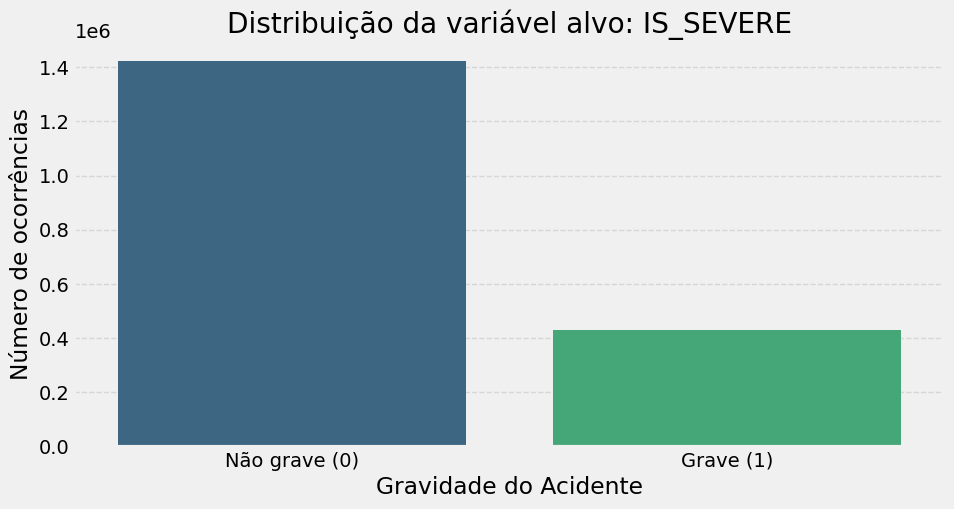

,proportion
IS_SEVERE,
0,76.86%
1,23.14%


In [ ]:
 # Observando a distribuição
sns.countplot(data=df, x='IS_SEVERE', palette='viridis')
plt.title('Distribuição da variável alvo: IS_SEVERE')
plt.xticks([0, 1], ['Não grave (0)', 'Grave (1)'])
plt.ylabel('Número de ocorrências')
plt.xlabel('Gravidade do Acidente')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

df['IS_SEVERE'].value_counts(normalize=True).map(lambda x: f"{x*100:.2f}%")

In [ ]:
serie_diaria = df.resample('D')['IS_SEVERE'].sum()
stl = STL(serie_diaria, period=7)  # período semanal (7 dias)
res = stl.fit()

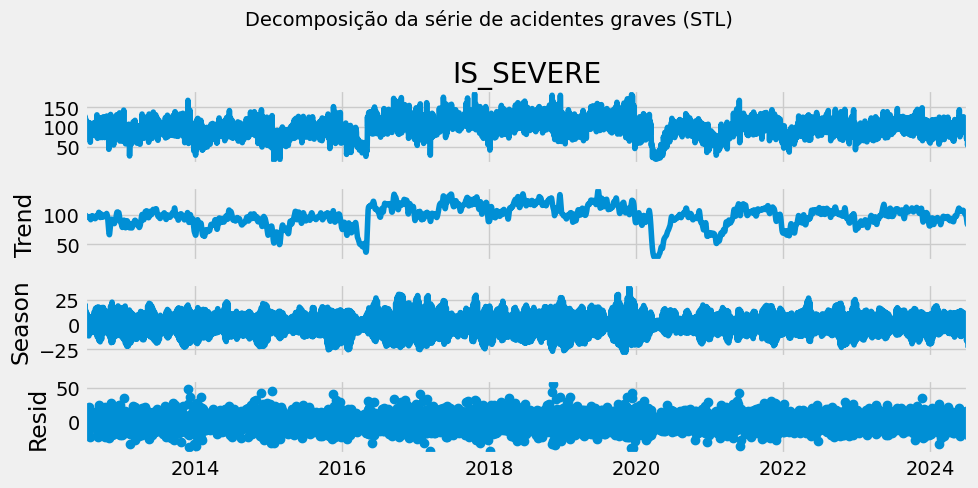

In [ ]:
# Observando
res.plot()
plt.suptitle('Decomposição da série de acidentes graves (STL)', fontsize=14)
plt.tight_layout()
plt.show()

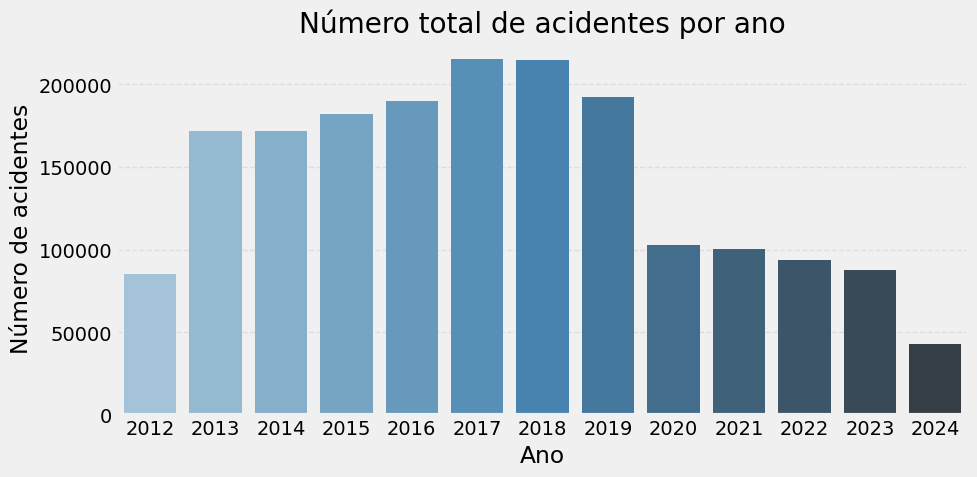

In [ ]:
# Conta número de acidentes por ano
acidentes_por_ano = df['CRASH_YEAR'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.barplot(x=acidentes_por_ano.index, y=acidentes_por_ano.values, palette='Blues_d')
plt.title('Número total de acidentes por ano')
plt.xlabel('Ano')
plt.ylabel('Número de acidentes')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**No gráfico acima vemos um alto índice de acidentes entre 2017 e 1019, a partir de 2020 temos uma grande quedo, muito por conta da pandemia, mas que se manteve em queda nos anos seguintes.**

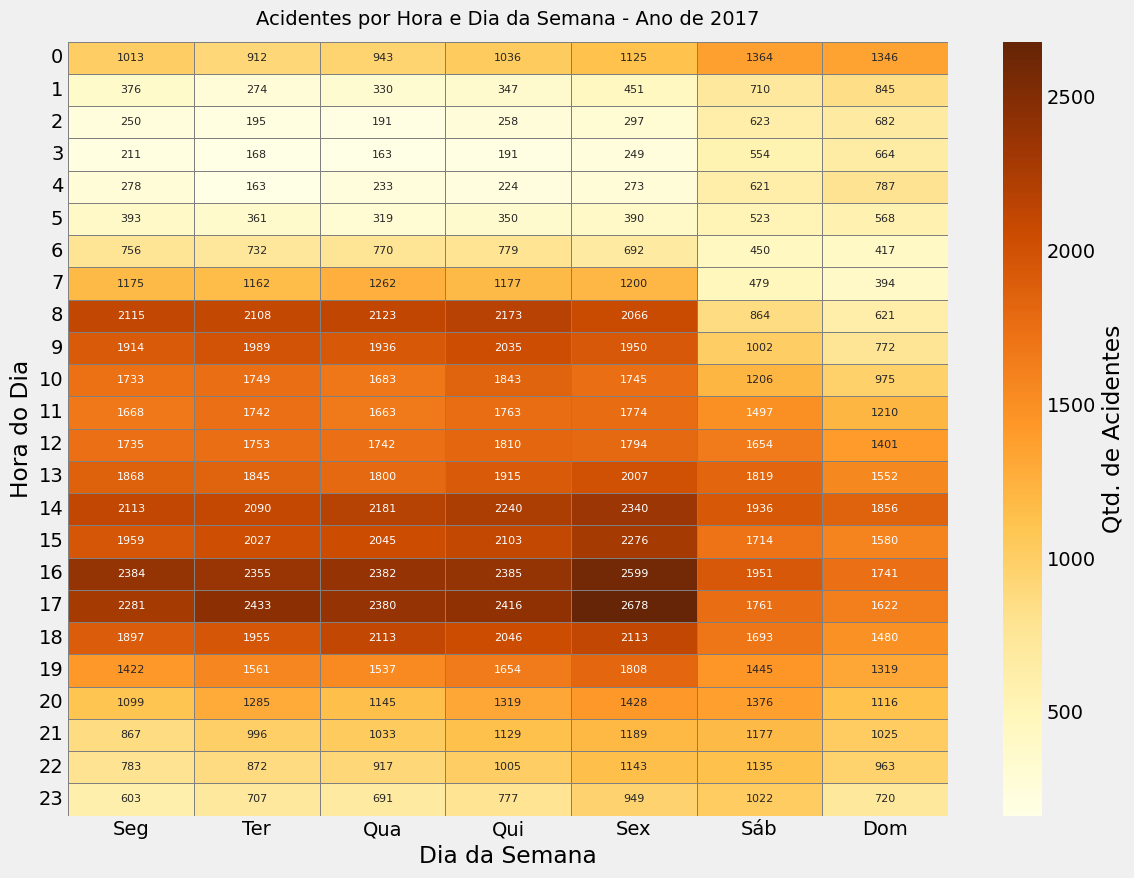

In [ ]:
# Filtra apenas o ano de 2017
df_2017 = df[df['CRASH_YEAR'] == 2017]

# Agrupar por hora do dia e dia da semana
heatmap_2017 = df_2017.groupby(['CRASH_HOUR', 'CRASH_WEEKDAY']).size().unstack(fill_value=0)

# Renomear colunas para dias da semana
dias_semana = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom']
heatmap_2017.columns = dias_semana

plt.figure(figsize=(12, 9))
sns.heatmap(
    heatmap_2017,
    cmap='YlOrBr',
    annot=True,
    fmt='d',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Qtd. de Acidentes'},
    annot_kws={"size": 8}
)

plt.title('Acidentes por Hora e Dia da Semana - Ano de 2017', fontsize=14, pad=12)
plt.xlabel('Dia da Semana')
plt.ylabel('Hora do Dia')
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

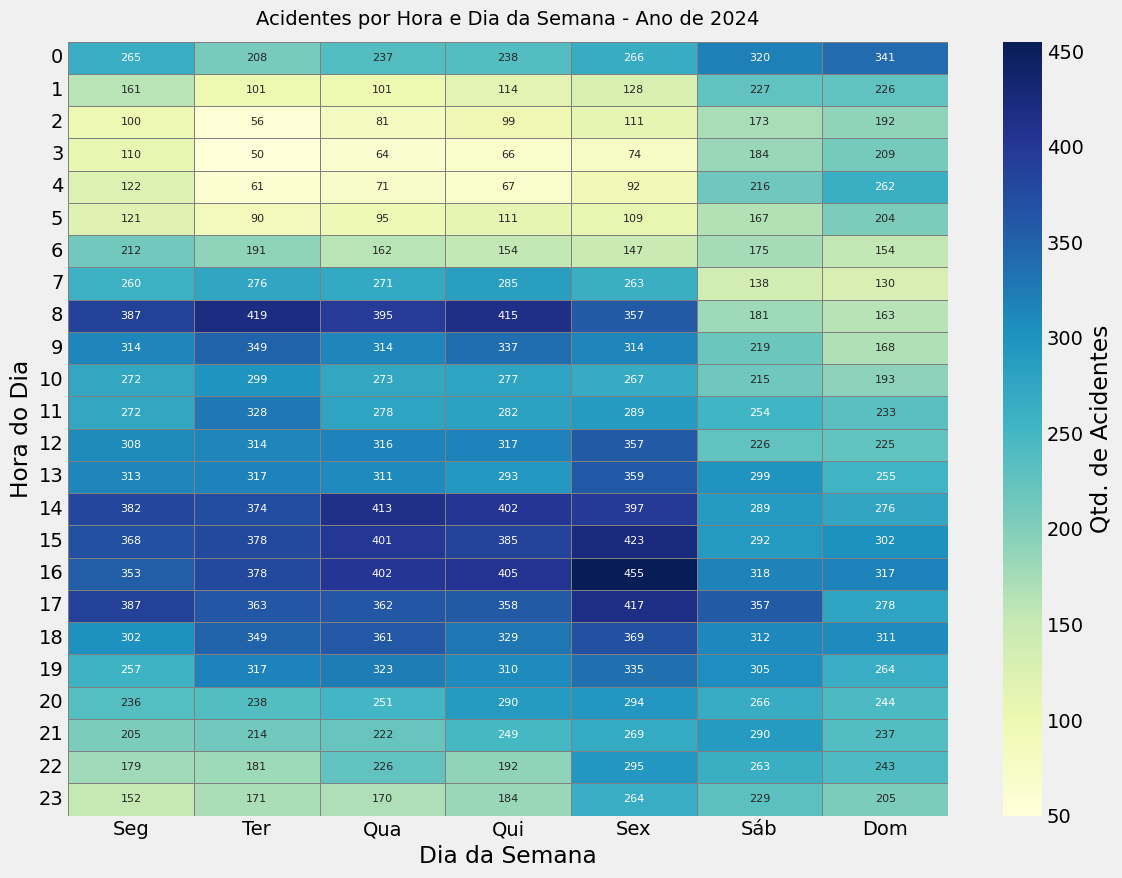

In [ ]:
# Filtra apenas o ano de 2024
df_2024 = df[df['CRASH_YEAR'] == 2024]

# Agrupar por hora e dia da semana
heatmap_2024 = df_2024.groupby(['CRASH_HOUR', 'CRASH_WEEKDAY']).size().unstack(fill_value=0)

# Renomear colunas com nomes dos dias
dias_semana = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom']
heatmap_2024.columns = dias_semana

plt.figure(figsize=(12, 9))
sns.heatmap(
    heatmap_2024,
    cmap='YlGnBu',
    annot=True,
    fmt='d',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Qtd. de Acidentes'},
    annot_kws={"size": 8}
)

plt.title('Acidentes por Hora e Dia da Semana - Ano de 2024', fontsize=14, pad=12)
plt.xlabel('Dia da Semana')
plt.ylabel('Hora do Dia')
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

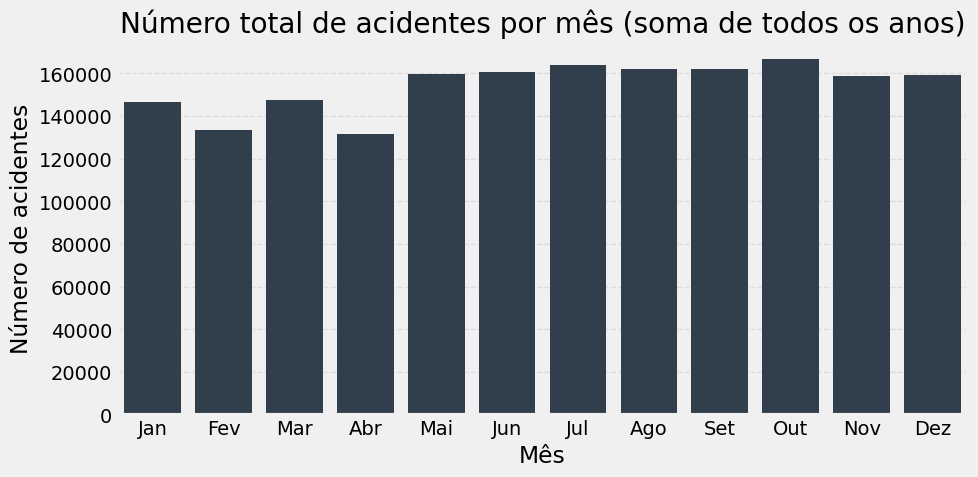

In [ ]:
# Conta o número total de acidentes por mês (de todos os anos)
acidentes_por_mes = df['CRASH_MONTH'].value_counts().sort_index()

# Mapeia os números para nomes dos meses
meses = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun',
         'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']

plt.figure(figsize=(10, 5))
sns.barplot(x=meses, y=acidentes_por_mes.values, color='#2C3E50')
plt.title('Número total de acidentes por mês (soma de todos os anos)')
plt.xlabel('Mês')
plt.ylabel('Número de acidentes')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Acima percebemos que entre maio e dezembro ocorrem a grande maioria dos acidentes.**

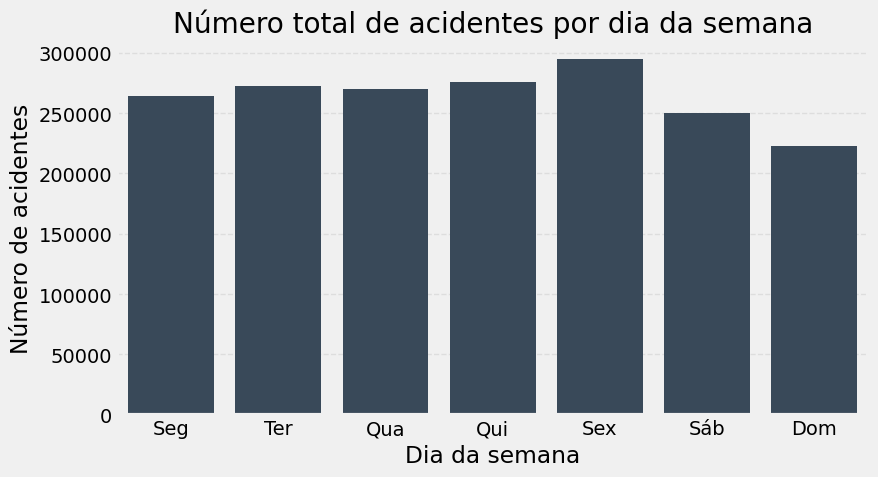

In [ ]:
# Contagem por dia da semana
dias_semana = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom']
acidentes_por_dia = df['CRASH_WEEKDAY'].value_counts().sort_index()

plt.figure(figsize=(9, 5))
sns.barplot(x=dias_semana, y=acidentes_por_dia.values, color='#34495E')
plt.title('Número total de acidentes por dia da semana')
plt.xlabel('Dia da semana')
plt.ylabel('Número de acidentes')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Acima notamos que de segunda a quinta muito estável, com um pico pouco maior na sexta, nos finais de semana temos menos acidentes, provavelmente por ter menos veículos nas ruas.**

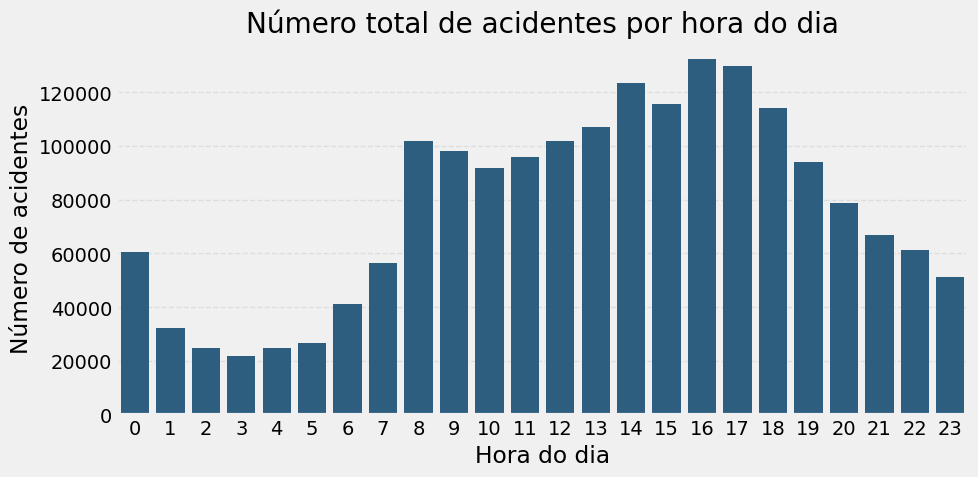

In [ ]:
# Contagem por hora (0–23)
acidentes_por_hora = df['CRASH_HOUR'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.barplot(x=acidentes_por_hora.index, y=acidentes_por_hora.values, color='#1F618D')
plt.title('Número total de acidentes por hora do dia')
plt.xlabel('Hora do dia')
plt.ylabel('Número de acidentes')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

**No gráfico acima vemos que a maioria dos acidentes acontecem na parte da tarde, principalmente entre 16h e 17h, muito por conta da hora de pico, após as 18h começa a cair.**

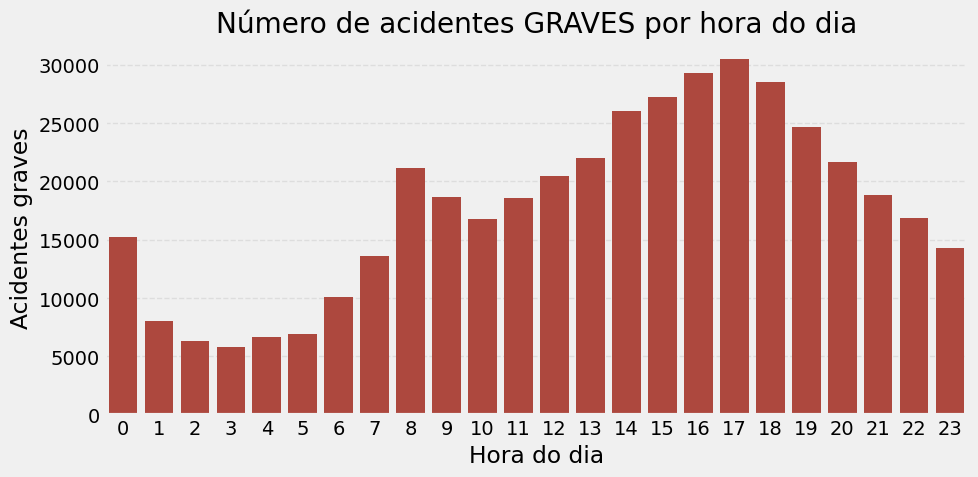

In [ ]:
# Filtrar apenas acidentes graves
df_graves = df[df['IS_SEVERE'] == 1]

# Contar acidentes graves por hora
acidentes_graves_por_hora = df_graves['CRASH_HOUR'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.barplot(x=acidentes_graves_por_hora.index, y=acidentes_graves_por_hora.values, color='#C0392B')
plt.title('Número de acidentes GRAVES por hora do dia')
plt.xlabel('Hora do dia')
plt.ylabel('Acidentes graves')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

**Acima só confirma o que o gráfico anterior nos informou, alto pico entre 16h e 17h, mas atenção para meia noite, que mostra ser um horário com muitos acidentes graves,, pode ser por causa de embriaguez, fadiga e sono.**

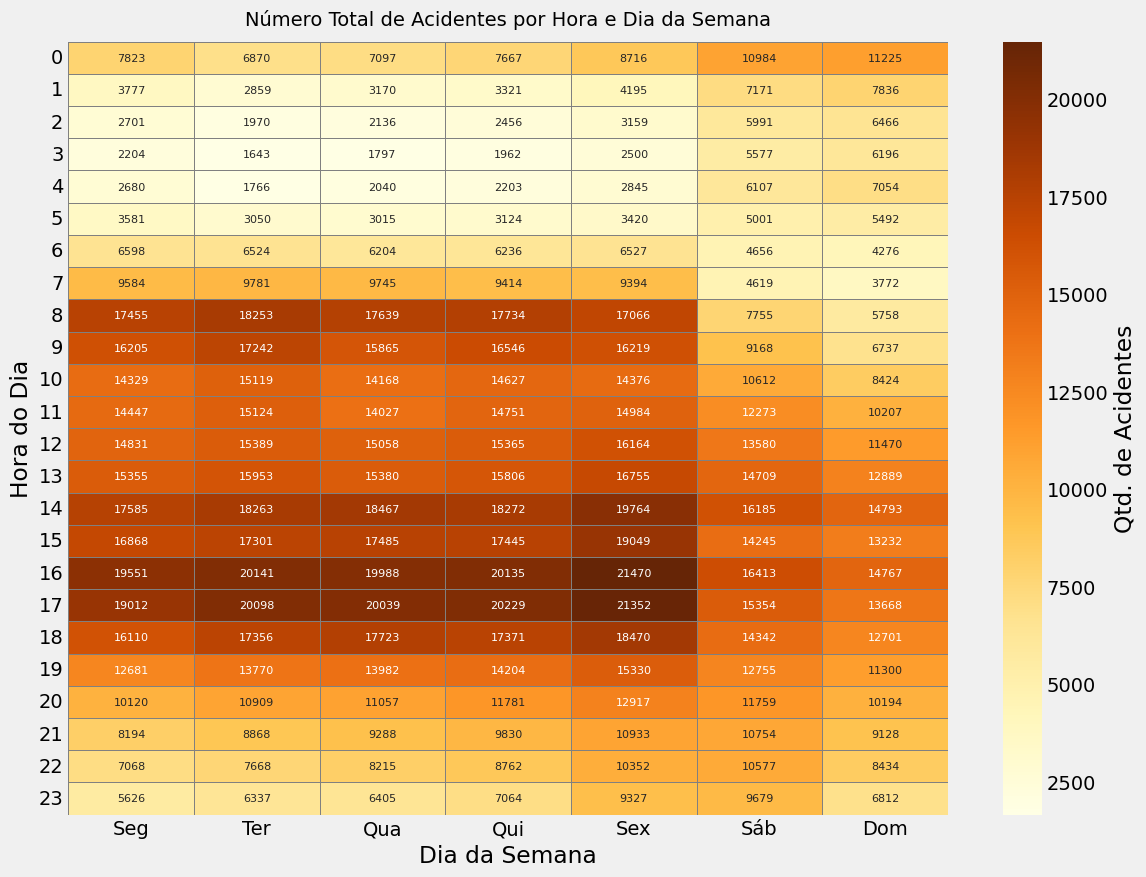

In [ ]:
# Tabela de acidentes por hora x dia da semana
heatmap_data = df.groupby(['CRASH_HOUR', 'CRASH_WEEKDAY']).size().unstack(fill_value=0)

# Reordena os dias corretamente
dias_semana = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom']
heatmap_data.columns = dias_semana

plt.figure(figsize=(12, 9))
sns.heatmap(
    heatmap_data,
    cmap='YlOrBr',
    annot=True,
    fmt='d',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Qtd. de Acidentes'},
    annot_kws={"size": 8}
)

plt.title('Número Total de Acidentes por Hora e Dia da Semana', fontsize=14, pad=12)
plt.xlabel('Dia da Semana')
plt.ylabel('Hora do Dia')
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


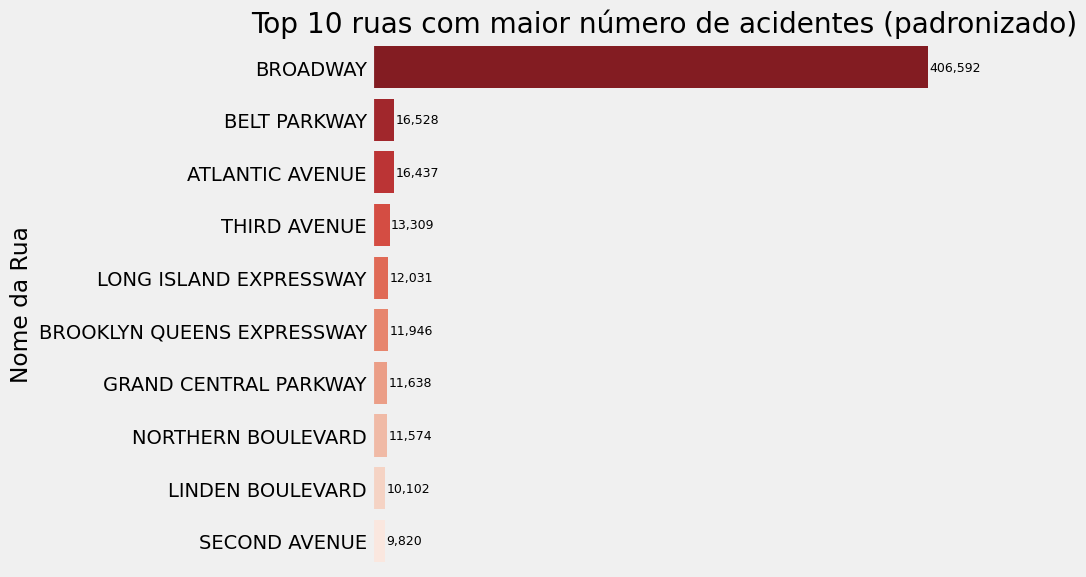

In [ ]:
# Contar top 10 ruas
top_ruas = df['ON STREET NAME'].value_counts(dropna=True).head(10)

plt.figure(figsize=(10, 6))
ax = sns.barplot(y=top_ruas.index, x=top_ruas.values, palette='Reds_r')

# Insere os números ao lado das barras
for i, v in enumerate(top_ruas.values):
    ax.text(v + 1000, i, f'{v:,}', color='black', va='center', fontsize=9)

plt.title('Top 10 ruas com maior número de acidentes (padronizado)')
plt.xlabel('')
plt.xticks([])
plt.ylabel('Nome da Rua')
plt.grid(False)
plt.tight_layout()
plt.show()


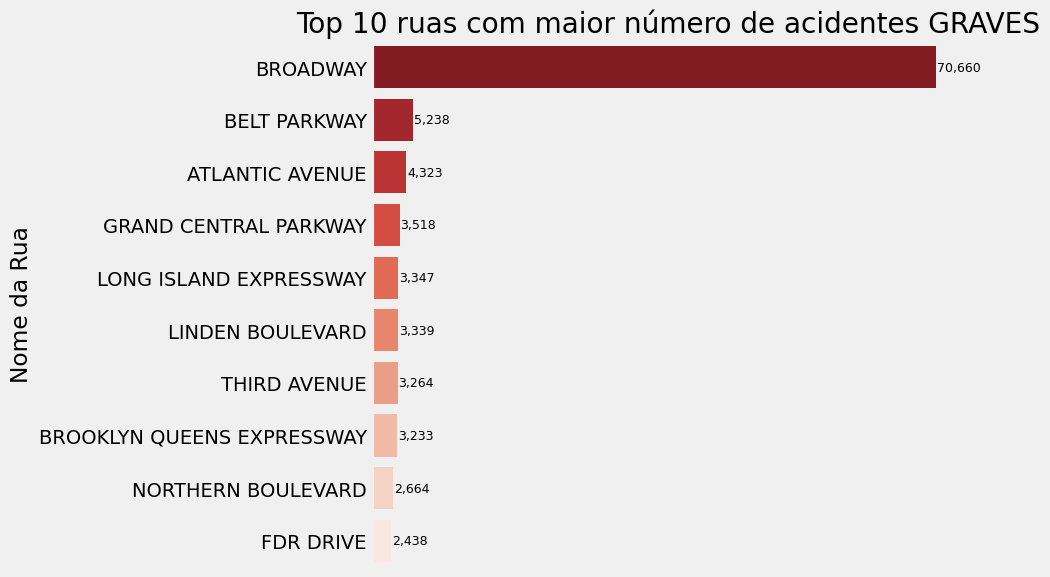

In [ ]:
# Filtrar apenas acidentes graves
df_graves = df[df['IS_SEVERE'] == 1]

# Contar top 10 ruas com mais acidentes graves
top_ruas_graves = df_graves['ON STREET NAME'].value_counts(dropna=True).head(10)

plt.figure(figsize=(10, 6))
ax = sns.barplot(y=top_ruas_graves.index, x=top_ruas_graves.values, palette='Reds_r')

# Insere os números ao lado das barras
for i, v in enumerate(top_ruas_graves.values):
    ax.text(v + 100, i, f'{v:,}', color='black', va='center', fontsize=9)

plt.title('Top 10 ruas com maior número de acidentes GRAVES')
plt.xlabel('')
plt.ylabel('Nome da Rua')
plt.xticks([])
plt.grid(False)
plt.tight_layout()
plt.show()


In [ ]:
# Criando a variável booleana de período COVID
df['IS_COVID_PERIOD'] = df.apply(
    lambda row: (row['CRASH_YEAR'] == 2020 and row['CRASH_MONTH'] >= 3) or
                (row['CRASH_YEAR'] == 2021), axis=1)

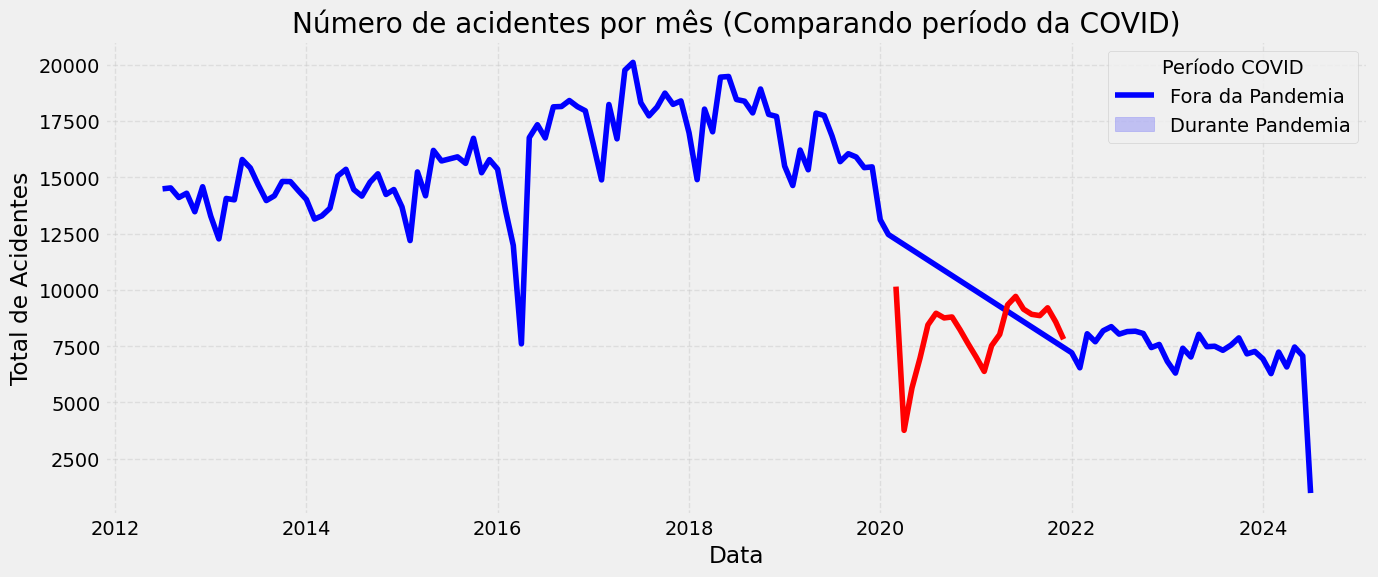

In [ ]:
# Agrupar por mês e flag covid
acidentes_covid = df.groupby(['CRASH_YEAR', 'CRASH_MONTH', 'IS_COVID_PERIOD']).size().reset_index(name='Total')

# Criar coluna com data para plotagem
acidentes_covid['DATA'] = pd.to_datetime(acidentes_covid['CRASH_YEAR'].astype(str) + '-' + acidentes_covid['CRASH_MONTH'].astype(str))

plt.figure(figsize=(14, 6))
sns.lineplot(data=acidentes_covid, x='DATA', y='Total', hue='IS_COVID_PERIOD', palette={True: 'red', False: 'blue'})

plt.title('Número de acidentes por mês (Comparando período da COVID)')
plt.xlabel('Data')
plt.ylabel('Total de Acidentes')
plt.legend(title='Período COVID', labels=['Fora da Pandemia', 'Durante Pandemia'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

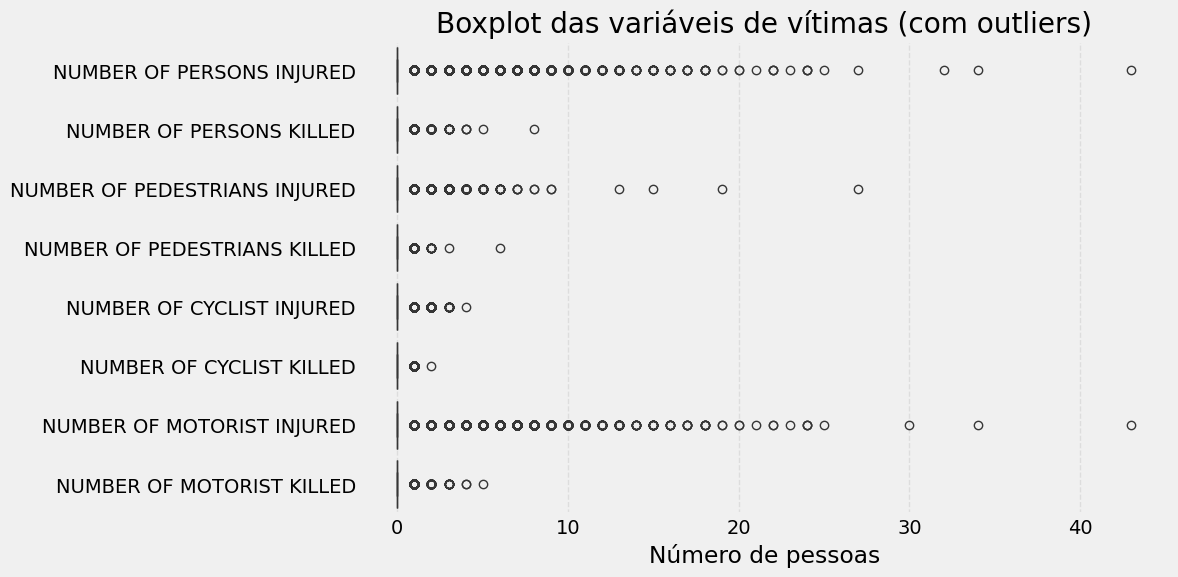

In [ ]:
# Boxplot para analisar outliers
variaveis_quantitativas = [
    'NUMBER OF PERSONS INJURED',
    'NUMBER OF PERSONS KILLED',
    'NUMBER OF PEDESTRIANS INJURED',
    'NUMBER OF PEDESTRIANS KILLED',
    'NUMBER OF CYCLIST INJURED',
    'NUMBER OF CYCLIST KILLED',
    'NUMBER OF MOTORIST INJURED',
    'NUMBER OF MOTORIST KILLED'
]

plt.figure(figsize=(12, 6))
sns.boxplot(data=df[variaveis_quantitativas], orient='h', palette='YlOrRd')
plt.title('Boxplot das variáveis de vítimas (com outliers)')
plt.xlabel('Número de pessoas')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


**Acima notamos outliers, mas não serão tratados por se tratarem de dados reais de acidentes de trânsito.**

In [ ]:
# Filtrando registros com mais de 10 feridos ou mortos
df_outliers = df[
    (df['NUMBER OF PERSONS INJURED'] > 10) |
    (df['NUMBER OF PERSONS KILLED'] > 10)
].copy()

# Adicionando coluna de total de vítimas
df_outliers['TOTAL_VICTIMS'] = df_outliers['NUMBER OF PERSONS INJURED'] + df_outliers['NUMBER OF PERSONS KILLED']

# Selecionando colunas relevantes
colunas = [
    'BOROUGH', 'ZIP CODE',
    'ON STREET NAME', 'CROSS STREET NAME',
    'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
    'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
    'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
    'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED',
    'TOTAL_VICTIMS'
]

# Ordenando do maior para o menor
df_outliers = df_outliers[colunas].sort_values(by='TOTAL_VICTIMS', ascending=False)

# Visualizando as 10 maiores ocorrências
df_outliers.head(10)


,BOROUGH,ZIP CODE,ON STREET NAME,CROSS STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,TOTAL_VICTIMS
CRASH_DATETIME,,,,,,,,,,,,,
2013-09-09 16:38:00,BROOKLYN,11213,HERKIMER STREET,ALBANY AVENUE,43.0,0.0,0,0,0,0,43,0,43.0
2023-04-07 22:24:00,QUEENS,11361.0,BELL BOULEVARD,45 ROAD,34.0,0.0,0,0,0,0,34,0,34.0
2015-04-17 11:43:00,QUEENS,11427.0,HILLSIDE AVENUE,HOLLIS COURT BOULEVARD,32.0,0.0,2,0,0,0,30,0,32.0
2017-05-18 11:54:00,MANHATTAN,10036.0,SEVENTH AVENUE,WEST 42 STREET,27.0,1.0,27,1,0,0,0,0,28.0
2023-12-28 17:50:00,STATEN ISLAND,10306.0,BISHOP STREET,DALTON AVENUE,25.0,0.0,0,0,0,0,25,0,25.0
2012-08-01 17:00:00,BROOKLYN,11207.0,BROADWAY,3 AVENUE,24.0,0.0,0,0,0,0,24,0,24.0
2013-07-22 18:09:00,BROOKLYN,11221.0,DEKALB AVENUE,TOMPKINS AVENUE,24.0,0.0,0,0,0,0,24,0,24.0
2015-01-07 15:58:00,BROOKLYN,11203,UTICA AVENUE,CLARENDON ROAD,24.0,0.0,0,0,0,0,24,0,24.0
2023-03-17 21:22:00,QUEENS,11428.0,220 STREET,JAMAICA AVENUE,23.0,0.0,0,0,0,0,23,0,23.0


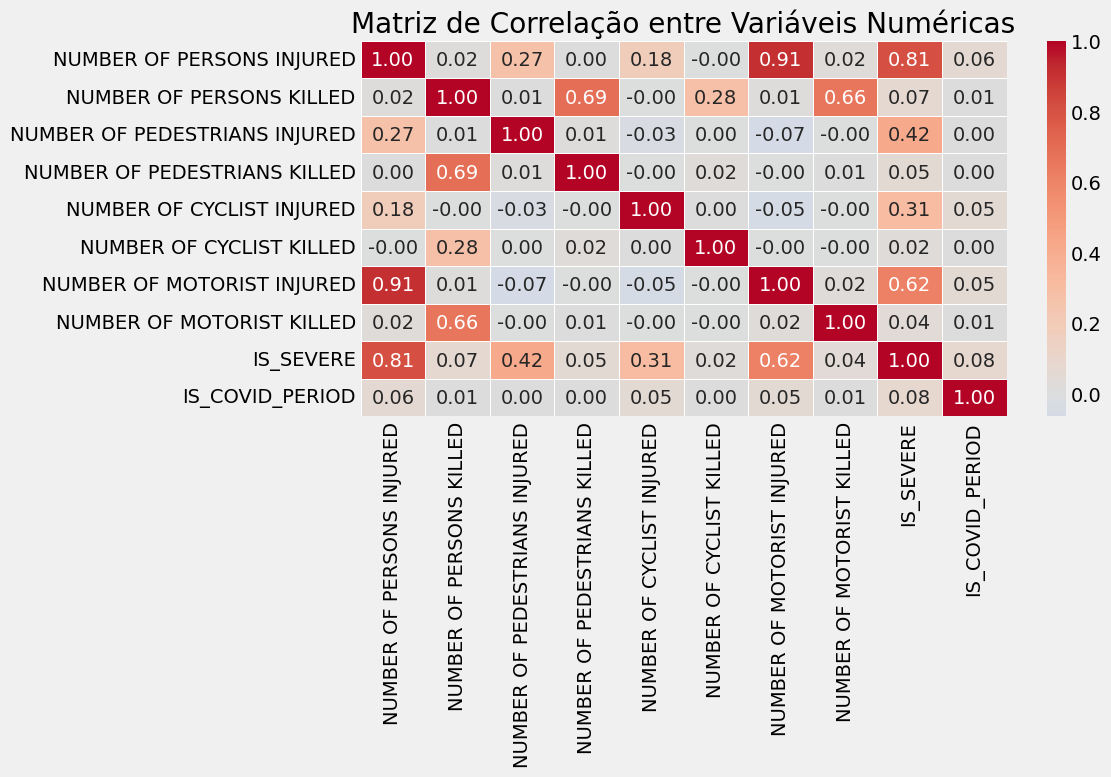

In [ ]:
# Selecionando variáveis numéricas relevantes (evitar colunas cíclicas e flags duplicadas)
variaveis_correlacao = [
    'NUMBER OF PERSONS INJURED',
    'NUMBER OF PERSONS KILLED',
    'NUMBER OF PEDESTRIANS INJURED',
    'NUMBER OF PEDESTRIANS KILLED',
    'NUMBER OF CYCLIST INJURED',
    'NUMBER OF CYCLIST KILLED',
    'NUMBER OF MOTORIST INJURED',
    'NUMBER OF MOTORIST KILLED',
    'IS_SEVERE',
    'IS_COVID_PERIOD'
]

# Calcular correlação
correlacao = df[variaveis_correlacao].corr()

# Plotar heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlacao, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt=".2f")

plt.title('Matriz de Correlação entre Variáveis Numéricas')
plt.tight_layout()
plt.show()

**Vamos exluir algumas variáveis com pouca colinearidade.**

In [ ]:
# Excluindo as colunas que não iremos utilizar
df.drop(columns=['NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST KILLED',
                'ON STREET NAME', 'CROSS STREET NAME', 'ZIP CODE'], inplace=True)

In [ ]:
# Codificação cíclica
df['HOUR_SIN'] = np.sin(2 * np.pi * df['CRASH_HOUR'] / 24)
df['HOUR_COS'] = np.cos(2 * np.pi * df['CRASH_HOUR'] / 24)

df['DAYOFWEEK_SIN'] = np.sin(2 * np.pi * df['CRASH_WEEKDAY'] / 7)
df['DAYOFWEEK_COS'] = np.cos(2 * np.pi * df['CRASH_WEEKDAY'] / 7)

df['MONTH_SIN'] = np.sin(2 * np.pi * df['CRASH_MONTH'] / 12)
df['MONTH_COS'] = np.cos(2 * np.pi * df['CRASH_MONTH'] / 12)

In [ ]:
# Excluindo as colunas que não iremos utilizar
df.drop(columns=['CRASH_HOUR', 'CRASH_WEEKDAY', 'CRASH_MONTH'], inplace=True)

In [ ]:
# Reduzindo o dataset de 2 milhões de linhas para 1 milhão devido ao baixo processamento
df = df.iloc[:1_000_000]

In [ ]:
df.shape

(1000000, 21)

In [ ]:
# Filtro para manter só as 10 categorias mais frequentes em cada coluna
colunas_para_codificar = [
    'BOROUGH',
    'CONTRIBUTING FACTOR VEHICLE 1',
    'CONTRIBUTING FACTOR VEHICLE 2',
    'VEHICLE TYPE CODE 1',
    'VEHICLE TYPE CODE 2'
]

for col in colunas_para_codificar:
    top10 = df[col].value_counts().nlargest(10).index
    df[col] = df[col].where(df[col].isin(top10), other='OUTROS')


df = pd.get_dummies(df, columns=colunas_para_codificar, drop_first=True)


In [ ]:
# Separando features e alvo
X = df.drop(columns=['IS_SEVERE'])  # features
y = df['IS_SEVERE']

In [ ]:
# Dividindo temporalmente (60% treino, 20% val, 20% teste)
n = len(df)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
X_test, y_test = X.iloc[val_end:], y.iloc[val_end:]

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"Total de colunas: {X_train.shape[1]}")

X_train shape: (600000, 59)
Total de colunas: 59


In [ ]:
# Padronizando
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Balanceamento (apenas no treino)
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

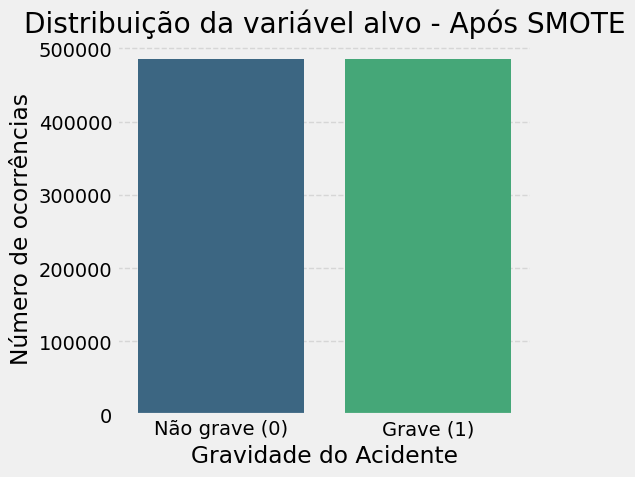

IS_SEVERE
0    50.00%
1    50.00%
Name: proportion, dtype: object


In [ ]:
# Observando o balanceamento
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_bal, palette='viridis')
plt.title('Distribuição da variável alvo - Após SMOTE')
plt.xticks([0, 1], ['Não grave (0)', 'Grave (1)'])
plt.ylabel('Número de ocorrências')
plt.xlabel('Gravidade do Acidente')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print(y_train_bal.value_counts(normalize=True).map(lambda x: f"{x*100:.2f}%"))

In [ ]:
# Verificando
print("Validação:", X_val_scaled.shape, y_val.value_counts())
print("Teste:", X_test_scaled.shape, y_test.value_counts())

Validação: (200000, 59) IS_SEVERE
0    162298
1     37702
Name: count, dtype: int64
Teste: (200000, 59) IS_SEVERE
0    161859
1     38141
Name: count, dtype: int64


**Vamos criar um modelo Multi-Layer Perceptron (MLP), também conhecido como uma rede neural feedforward ou rede neural artificial (ANN) simples, é a forma mais básica de uma rede neural profunda. Vamos usar também a regularização L2 que é uma técnica usada para evitar o overfitting (sobreajuste) em modelos de Machine Learning, incluindo MLPs. Overfitting ocorre quando o modelo aprende os dados de treinamento tão bem, incluindo o ruído, que ele perde a capacidade de generalizar para novos dados não vistos.**

In [ ]:
# Criando modelo MLP com regularização L2
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_bal.shape[1],), kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Early stopping para evitar overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Treinamento do modelo
history = model.fit(
    X_train_bal, y_train_bal,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1)


Epoch 1/50
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9703 - loss: 0.1523 - val_accuracy: 0.9284 - val_loss: 0.8951
Epoch 2/50
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.9986 - loss: 0.0135 - val_accuracy: 0.9948 - val_loss: 0.1324
Epoch 3/50
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9986 - loss: 0.0118 - val_accuracy: 0.9938 - val_loss: 0.0991
Epoch 4/50
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9985 - loss: 0.0112 - val_accuracy: 0.7990 - val_loss: 0.3386
Epoch 5/50
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9986 - loss: 0.0104 - val_accuracy: 0.9770 - val_loss: 0.1492
Epoch 6/50
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9986 - loss: 0.0098 - val_accuracy: 0.9804 - val_loss: 0.3551
Epoch 7/50
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9985 - loss: 0.0097 - val_accuracy: 0.7681 - val_loss: 0.3889
Epoch 8/50
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9985 - loss: 0.

In [ ]:
# Avaliação no conjunto de validação
val_pred_proba = model.predict(X_val_scaled)
val_pred = (val_pred_proba > 0.5).astype(int)

print("\n📊 Avaliação na Validação:")
print(classification_report(y_val, val_pred))
print("🔍 Val AUC-ROC:", roc_auc_score(y_val, val_pred_proba))

# Avaliação no conjunto de teste
test_pred_proba = model.predict(X_test_scaled)
test_pred = (test_pred_proba > 0.5).astype(int)

print("\n📊 Avaliação no Teste:")
print(classification_report(y_test, test_pred))
print("🔍 Test AUC-ROC:", roc_auc_score(y_test, test_pred_proba))

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step

📊 Avaliação na Validação:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    162298
           1       0.98      0.99      0.98     37702

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

🔍 Val AUC-ROC: 0.9969686350397424
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step

📊 Avaliação no Teste:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    161859
           1       0.98      0.99      0.98     38141

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

🔍 Test AUC-ROC: 0.9981426824099112


**Accuracy (Acurácia):** O modelo alcançou 99% de acurácia tanto na validação quanto no teste, o que é extremamente alto. No entanto, como estamos lidando com um problema desbalanceado (apenas ~19% dos acidentes são graves), a acurácia sozinha pode ser enganosa. Por isso, damos mais atenção a métricas como F1-score e AUC, que oferecem uma visão mais fiel da performance real do modelo, especialmente na identificação dos acidentes graves.

**Precision (Precisão):** Na validação, dos casos em que o modelo previu que o acidente seria grave, 100% estavam corretos. No teste, esse valor se manteve 100%. Isso indica que o modelo cometeu quase nenhum falso positivo, o que é essencial em cenários críticos como trânsito urbano e resposta a emergências, onde não se pode errar ao classificar um acidente como grave se ele não for.

**Recall (Revocação / Sensibilidade):** Na validação, o modelo conseguiu identificar 99% dos acidentes realmente graves. No teste, a sensibilidade foi de 99%, ou seja, mesmo em um conjunto real desbalanceado, o modelo manteve excelente cobertura da classe minoritária, conseguindo detectar praticamente todos os acidentes graves. Isso é essencial para não deixar eventos críticos passarem despercebidos.

**F1 Score:** O modelo atingiu 0.98 na validação e 0.98 no teste, o que mostra um equilíbrio quase perfeito entre precisão e revocação. Esse resultado confirma a robustez do modelo, mesmo diante de dados ruidosos e de alta variabilidade, como acidentes de trânsito.

**AUC (Área sob a Curva ROC):** Obtivemos AUC de 0.9969 na validação e 0.9981 no teste o que é um desempenho praticamente perfeito. Valores acima de 0.99 indicam que o modelo tem altíssima capacidade discriminativa, ou seja, ele consegue separar com extrema precisão os acidentes graves dos não graves, mesmo sob diferentes limiares de decisão.

**O modelo demonstrou performance de alto nível, com extrema precisão, cobertura e estabilidade. A rede neural MLP, aliada ao pré-processamento robusto, entregou um classificador confiável para auxiliar na priorização de atendimentos, análise de risco urbano ou integração com sistemas inteligentes de tráfego.**

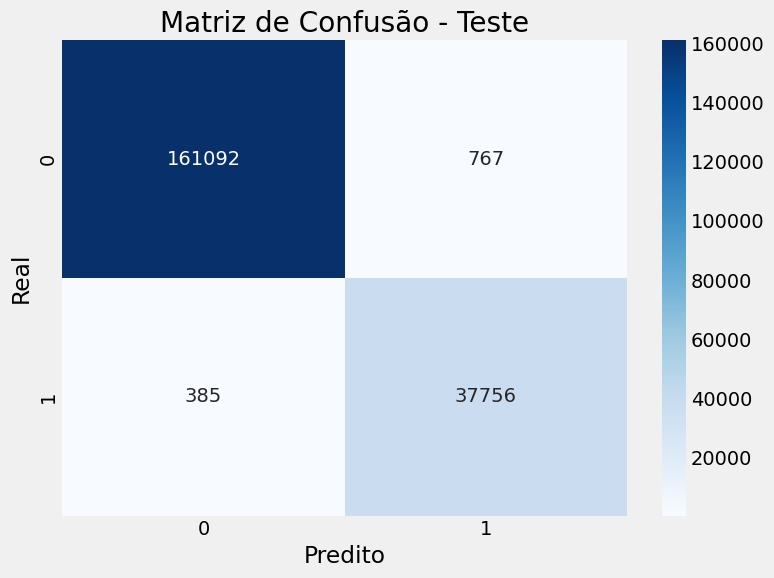

In [ ]:
# Matriz de confusão
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Teste')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

**Na matriz de confusão acima, observamos que o modelo classificou corretamente 161.092 acidentes não graves, representando os Verdadeiros Negativos (TN). Além disso, ele acertou 37.756 acidentes graves, os chamados Verdadeiros Positivos (TP). Tivemos apenas 767 Falsos Positivos (FP), ou seja, o modelo indicou que alguns acidentes seriam graves, mas na prática não foram. Esse número extremamente baixo é muito positivo, pois evita alarmes falsos, o que é crucial em contextos de emergência e resposta rápida. Já os 385 Falsos Negativos (FN) representam casos em que o modelo não classificou como grave um acidente que de fato foi severo. Ainda assim, o modelo alcançou um recall de 999% e uma precisão de 100% para a classe de acidentes graves, o que mostra altíssima capacidade de identificar corretamente os eventos críticos, com baixíssimo custo de erro.**

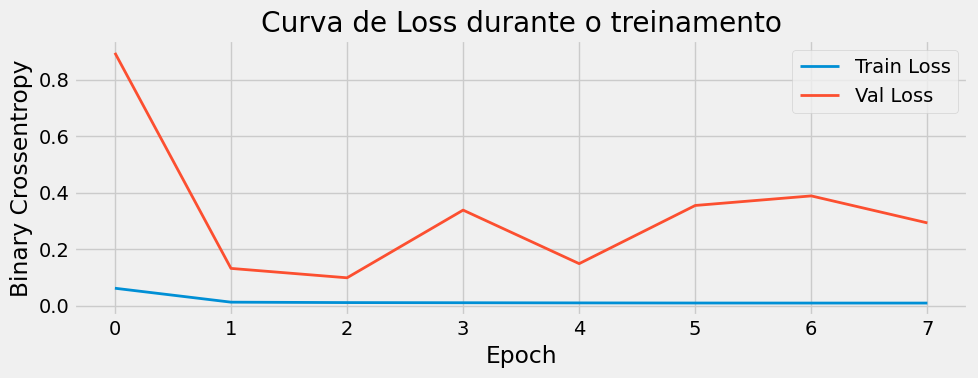

In [ ]:
# Curva de treinamento
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.title('Curva de Loss durante o treinamento')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**O gráfico acima mostra a evolução da função de perda (Binary Crossentropy) ao longo das épocas de treinamento da rede neural. A linha azul representa a perda no conjunto de treinamento, enquanto a linha vermelha representa a perda no conjunto de validação. Logo nas primeiras épocas, observamos uma redução acentuada do erro de treinamento, indicando que o modelo conseguiu aprender rapidamente os padrões nos dados balanceados. A loss de validação também caiu, mas com flutuações moderadas, o que é comum em conjuntos com ruído natural como acidentes de trânsito.**

**O uso de regularização com Dropout e L2, combinado com EarlyStopping, evitou o overfitting, pois a validação não disparou em nenhum momento, e o treinamento foi interrompido automaticamente após 7 épocas, momento em que o modelo já havia atingido ótima generalização. Essa curva demonstra que o modelo aprendeu com rapidez e eficiência, mantendo a estabilidade na validação.**

**Este projeto desenvolveu um modelo de classificação robusto para prever a gravidade de acidentes de trânsito com base em dados históricos de colisões na cidade de Nova York. Através de uma ampla limpeza, engenharia de variáveis e balanceamento dos dados, foi possível treinar uma rede neural de alta performance, atingindo métricas excelentes como AUC-ROC de 0.99, além de alta precisão, recall e F1-score tanto na validação quanto no teste. Os resultados demonstram forte capacidade do modelo em identificar padrões críticos associados a acidentes graves, oferecendo uma ferramenta eficaz para apoiar políticas públicas de segurança viária e ações preventivas nas áreas de maior risco.**